In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df
def chip_graph(df, title, save = False):
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(data=df, x='-log10(pval) bins', 
                y = 'counts', hue="chipseq", order = choices)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),title='CHiPseq Cell Line', fontsize=20)
    plt.setp(ax.get_legend().get_title(), fontsize='20')

    ax.set_title(title, fontsize=25)

    plt.xlabel('-log10(p-value) Bins',fontsize=20)
    sns.despine()
    plt.ylabel('Counts',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
#     if save == True:
#         #atac_graph_out = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/figure/2023/CRISPRi/ATACseq/'
#         plt.savefig(atac_graph_out + title + '.png',
#                    dpi = 1000, bbox_inches='tight')

In [3]:
out_path = '../../Data/CHiP_Histone/Pval/'

results_df = pd.read_csv(out_path+'CHIP_Pval.csv')
results_df['DataSetID'] = results_df[['DataSet', 'Domain', 'condition']].agg("_".join, axis=1)

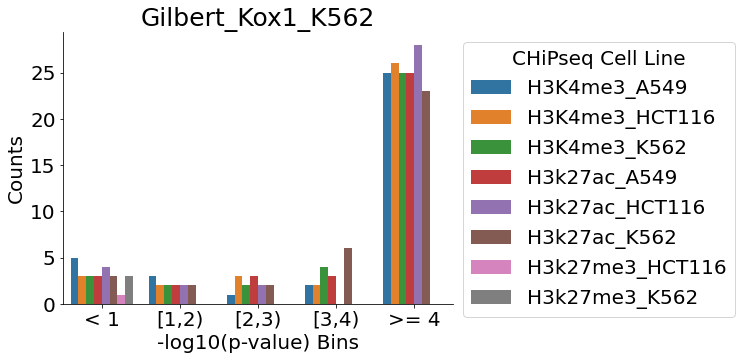

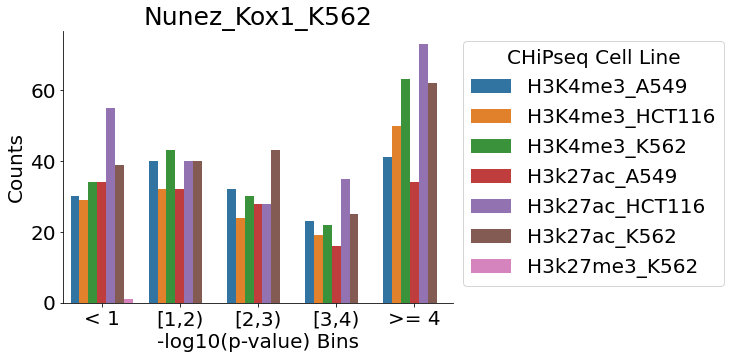

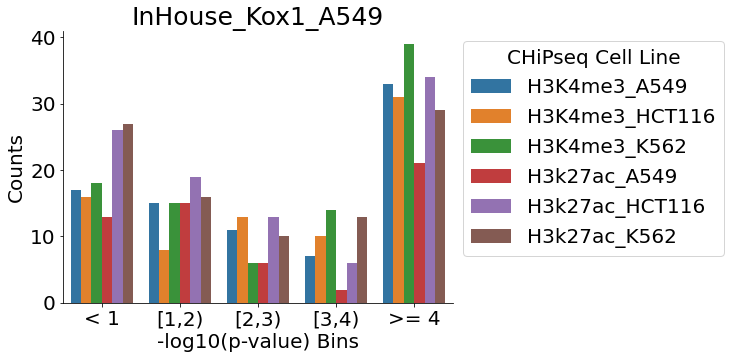

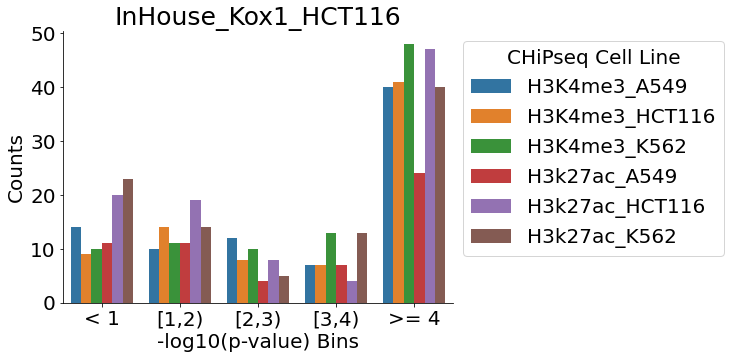

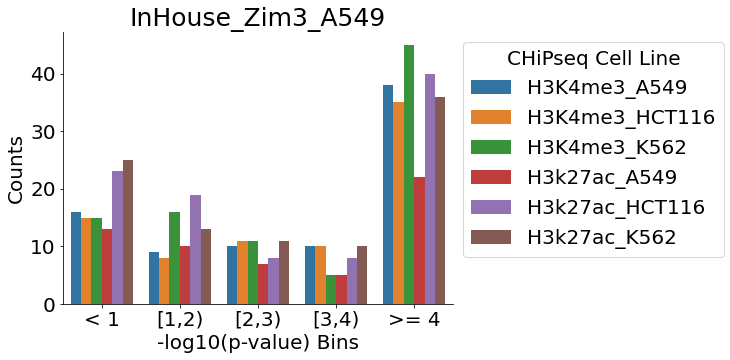

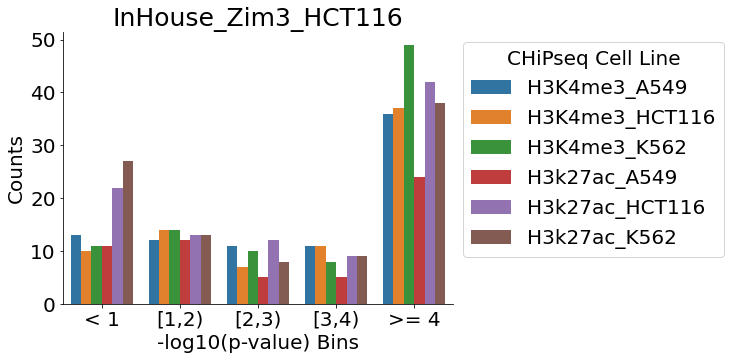

In [4]:
allDataCount = pd.DataFrame()
for dataset in results_df.DataSetID.unique():
    select_pval = results_df[results_df.DataSetID == dataset].copy()
    select_pval['-log10(pval)'] = -np.log10(select_pval['pval'])
    select_pval = categorize_pval(select_pval)
    select_count = pd.DataFrame(select_pval.groupby(['-log10(pval) bins', 'chipseq']).size().reset_index(name='counts'))
    select_count['DataSetID'] = dataset
    allDataCount = pd.concat([allDataCount, select_count])
    chip_graph(select_count, dataset)

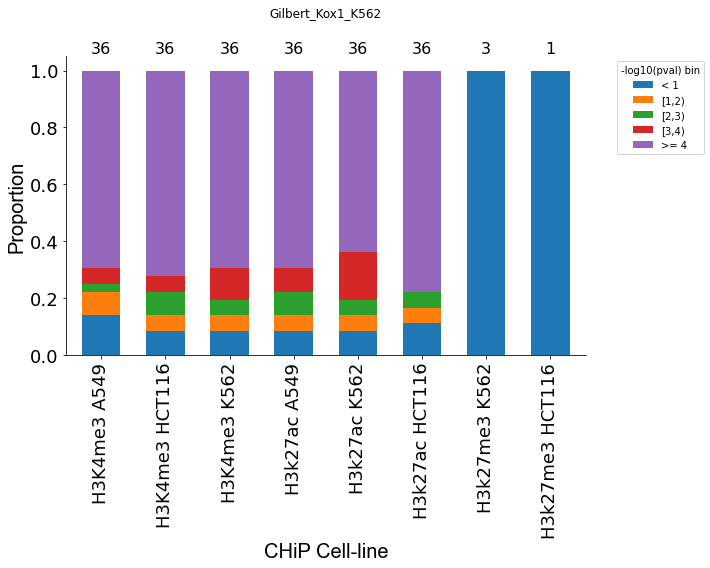

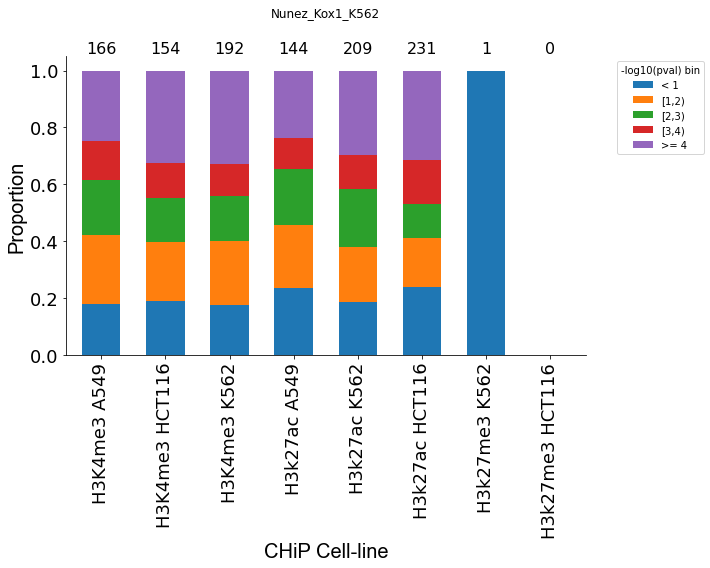

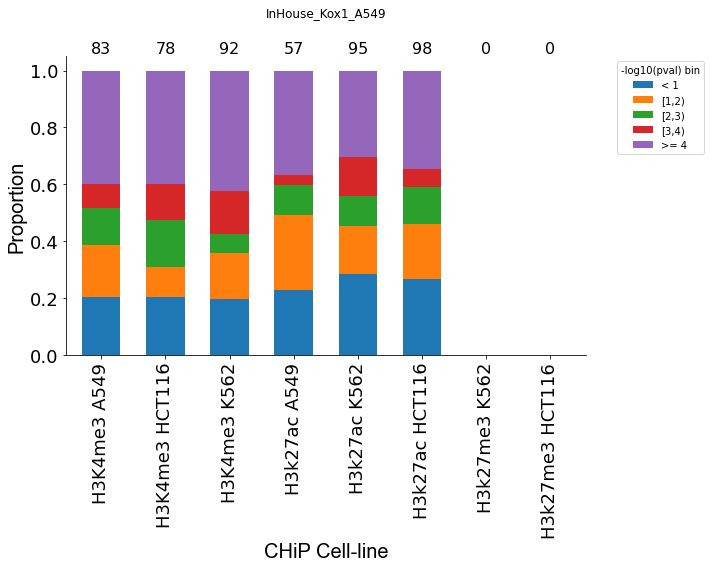

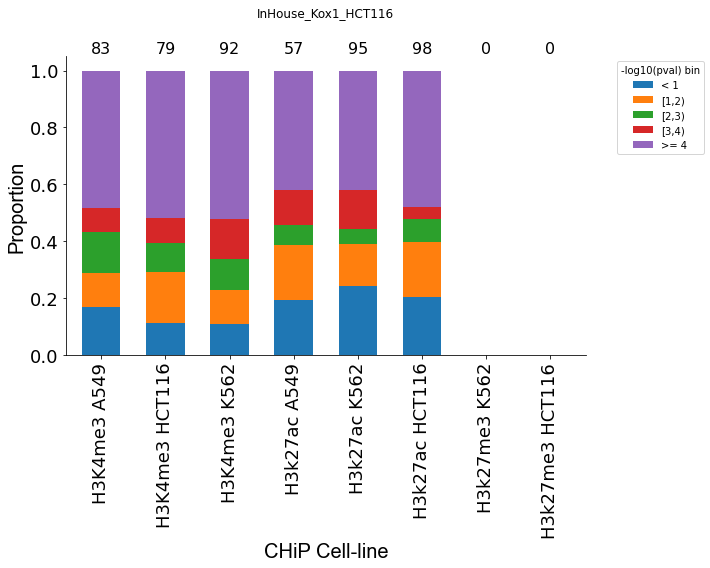

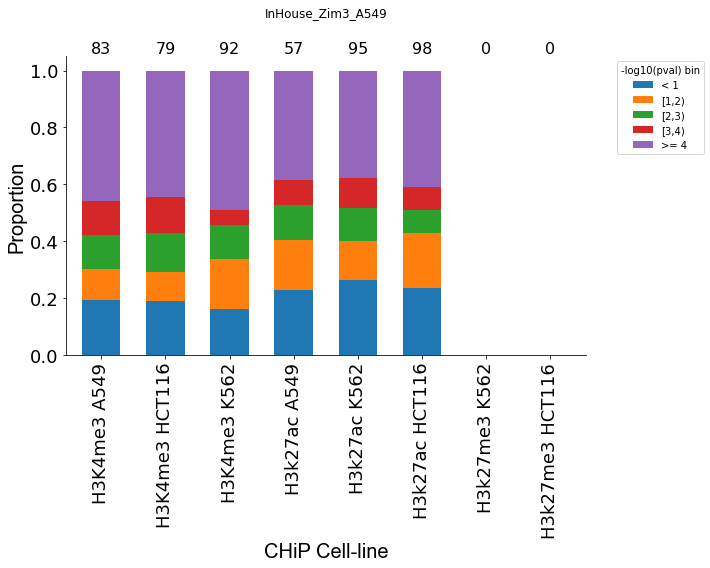

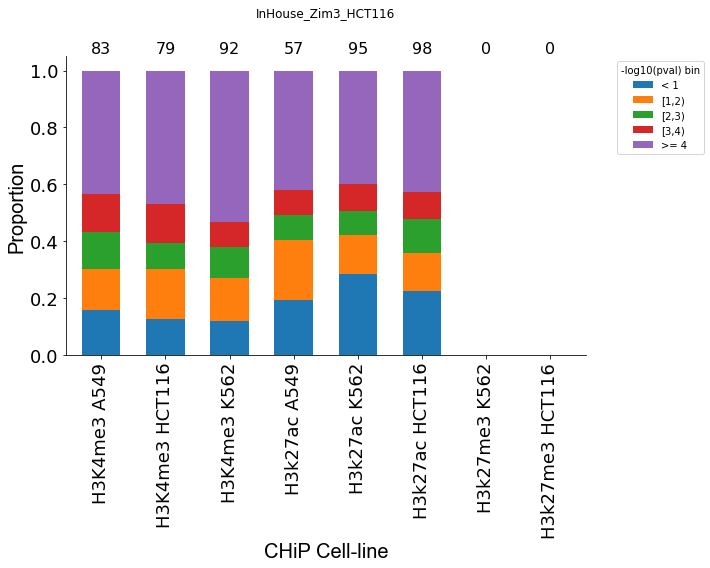

In [5]:
required_columns = ['H3K4me3_A549','H3K4me3_HCT116','H3K4me3_K562','H3k27ac_A549','H3k27ac_K562','H3k27ac_HCT116','H3k27me3_K562', 'H3k27me3_HCT116']
graph_pathout = '../../Figure/Figure 3/Individual Figures/'

for selectData in allDataCount['DataSetID'].unique():
    select_count = allDataCount[allDataCount.DataSetID == selectData].copy()

    grouped_df = select_count.groupby(['-log10(pval) bins', 'chipseq'])['counts'].sum().unstack().fillna(0)
    
    # Add missing required columns with zeros
    for col in required_columns:
        if (col not in grouped_df.columns):
            grouped_df[col] = 0
    
    # Ensure the columns are in the desired order
    grouped_df = grouped_df[required_columns]

    # Calculate percentages
    grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
    grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)', '[2,3)','[3,4)','>= 4']]
    
    # Change the index format
    grouped_df_percentage.index = grouped_df_percentage.index.str.replace('_', ' ')
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))

    grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.6)

    # Add percentages to the bars and the total count
    for i in range(grouped_df_percentage.shape[0]):
        total = 0
        totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
        # Add total count text on top of each stack
        ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=8*2, fontweight='light', color='black')

    plt.ylabel('Proportion', fontsize=20, fontfamily='Arial')
    plt.xlabel('CHiP Cell-line', fontsize=20, fontfamily='Arial')
    plt.title(selectData, pad=20*2)
    ax.tick_params(axis='both', labelsize=18)
    plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.savefig(graph_pathout + selectData+"_chip_v2.pdf", dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
grouped_df_percentage

-log10(pval) bins,< 1,"[1,2)","[2,3)","[3,4)",>= 4
chipseq,,,,,
H3K4me3 A549,0.156627,0.144578,0.132530,0.132530,0.433735
H3K4me3 HCT116,0.126582,0.177215,0.088608,0.139241,0.468354
H3K4me3 K562,0.119565,0.152174,0.108696,0.086957,0.532609
H3k27ac A549,0.192982,0.210526,0.087719,0.087719,0.421053
H3k27ac K562,0.284211,0.136842,0.084211,0.094737,0.400000
H3k27ac HCT116,0.224490,0.132653,0.122449,0.091837,0.428571
H3k27me3 K562,NaN,NaN,NaN,NaN,NaN
H3k27me3 HCT116,NaN,NaN,NaN,NaN,NaN


In [7]:
results_df.chipseq.value_counts()

H3k27ac_HCT116     659
H3k27ac_K562       625
H3K4me3_K562       596
H3K4me3_A549       534
H3K4me3_HCT116     505
H3k27ac_A549       408
H3k27me3_K562        4
H3k27me3_HCT116      1
Name: chipseq, dtype: int64

In [8]:
results_df[['DataSetID','chipseq']].value_counts()

DataSetID            chipseq        
Nunez_Kox1_K562      H3k27ac_HCT116     231
                     H3k27ac_K562       209
                     H3K4me3_K562       192
                     H3K4me3_A549       166
                     H3K4me3_HCT116     154
                     H3k27ac_A549       144
InHouse_Zim3_HCT116  H3k27ac_HCT116      98
InHouse_Kox1_HCT116  H3k27ac_HCT116      98
InHouse_Zim3_A549    H3k27ac_HCT116      98
InHouse_Kox1_A549    H3k27ac_HCT116      98
InHouse_Kox1_HCT116  H3k27ac_K562        95
InHouse_Zim3_A549    H3k27ac_K562        95
InHouse_Zim3_HCT116  H3k27ac_K562        95
InHouse_Kox1_A549    H3k27ac_K562        95
InHouse_Kox1_HCT116  H3K4me3_K562        92
InHouse_Zim3_A549    H3K4me3_K562        92
InHouse_Kox1_A549    H3K4me3_K562        92
InHouse_Zim3_HCT116  H3K4me3_K562        92
InHouse_Kox1_HCT116  H3K4me3_A549        83
InHouse_Zim3_HCT116  H3K4me3_A549        83
InHouse_Zim3_A549    H3K4me3_A549        83
InHouse_Kox1_A549    H3K4me3_A549      

In [9]:
 

allDataCount[['Histone Marker', 'Cell-line']] = allDataCount['chipseq'].str.split('_', expand=True)

In [10]:
allDataCount.DataSetID.unique()

array(['Gilbert_Kox1_K562', 'Nunez_Kox1_K562', 'InHouse_Kox1_A549',
       'InHouse_Kox1_HCT116', 'InHouse_Zim3_A549', 'InHouse_Zim3_HCT116'],
      dtype=object)

In [11]:
allDataCount_InHouse_Kox1_A549 = allDataCount[allDataCount.DataSetID == 'InHouse_Kox1_A549']
allDataCount_InHouse_Kox1_A549

,-log10(pval) bins,chipseq,counts,DataSetID,Histone Marker,Cell-line
0,< 1,H3K4me3_A549,17,InHouse_Kox1_A549,H3K4me3,A549
1,< 1,H3K4me3_HCT116,16,InHouse_Kox1_A549,H3K4me3,HCT116
2,< 1,H3K4me3_K562,18,InHouse_Kox1_A549,H3K4me3,K562
3,< 1,H3k27ac_A549,13,InHouse_Kox1_A549,H3k27ac,A549
4,< 1,H3k27ac_HCT116,26,InHouse_Kox1_A549,H3k27ac,HCT116
5,< 1,H3k27ac_K562,27,InHouse_Kox1_A549,H3k27ac,K562
6,>= 4,H3K4me3_A549,33,InHouse_Kox1_A549,H3K4me3,A549
7,>= 4,H3K4me3_HCT116,31,InHouse_Kox1_A549,H3K4me3,HCT116
8,>= 4,H3K4me3_K562,39,InHouse_Kox1_A549,H3K4me3,K562
9,>= 4,H3k27ac_A549,21,InHouse_Kox1_A549,H3k27ac,A549


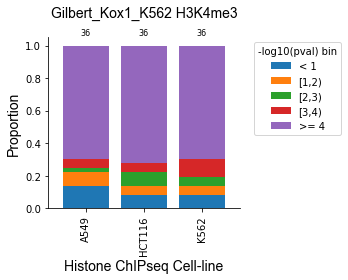

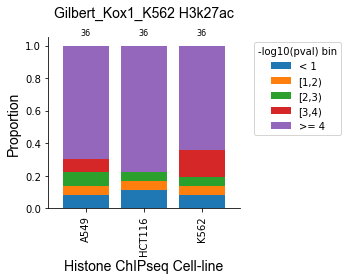

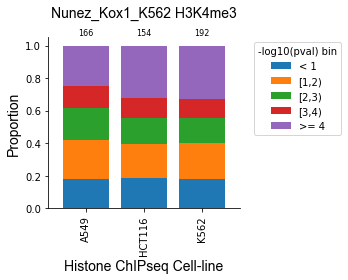

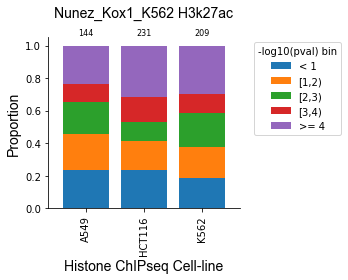

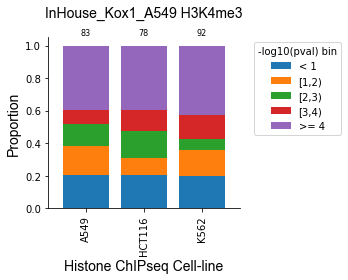

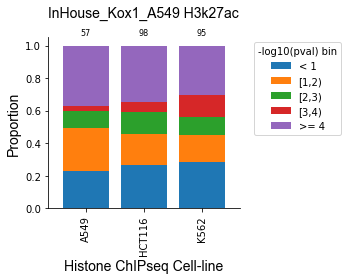

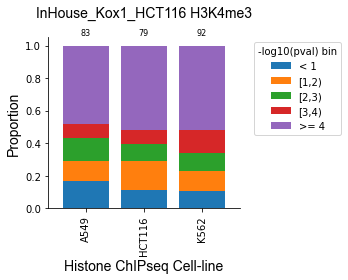

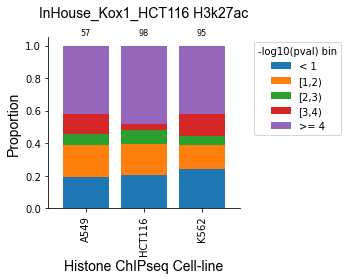

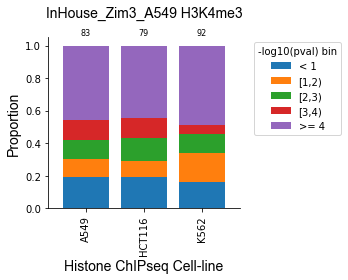

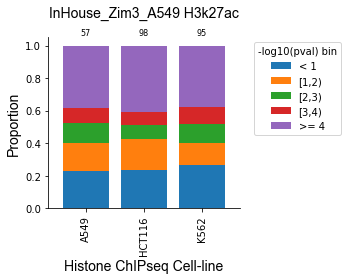

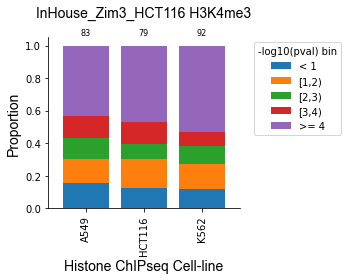

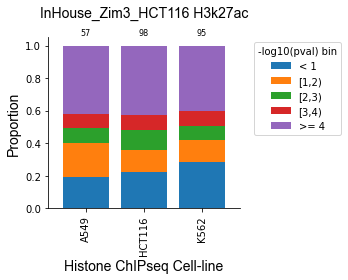

In [12]:
required_columns = ['A549','HCT116','K562']
dataset = allDataCount.DataSetID.unique()
for selectData in dataset:
    selectData_df = allDataCount[allDataCount['DataSetID'] == selectData].copy()

    for selectHistone in ['H3K4me3', 'H3k27ac']:
        select_count = selectData_df[selectData_df['Histone Marker'] == selectHistone].copy()

        grouped_df = select_count.groupby(['-log10(pval) bins', 'Cell-line'])['counts'].sum().unstack().fillna(0)
        # Add missing required columns with zeros
        for col in required_columns:
            if (col not in grouped_df.columns):
                grouped_df[col] = 0


        # Calculate percentages
        grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
        grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)', '[2,3)','[3,4)','>= 4']]

        # Change the index format
        grouped_df_percentage.index = grouped_df_percentage.index.str.replace('_', ' ')
        # Plotting
        fig, ax = plt.subplots(figsize=(5, 4))

        grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.8)

        # Add percentages to the bars and the total count
        for i in range(grouped_df_percentage.shape[0]):
            total = 0
            totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
            # Add total count text on top of each stack
            ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=8, fontweight='light', color='black')

        plt.ylabel('Proportion', fontsize=14, fontfamily='Arial')
        plt.xlabel('Histone ChIPseq Cell-line', fontsize=14, fontfamily='Arial')
        plt.title(f'{selectData} {selectHistone}', pad=20, fontsize=14, fontfamily='Arial')
        ax.tick_params(axis='both', labelsize=10)
        plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
        sns.despine()
        plt.tight_layout()
        plt.savefig(graph_pathout + selectData+"_"+selectHistone+"_"+"individual.pdf", dpi=300, bbox_inches='tight')
        plt.show()
